<a href="https://colab.research.google.com/github/evauclin/Deep_Learning_NLP_Project/blob/main/NLP_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet - Real or Not? NLP with Disaster Tweets

## Project description 

* Competition - https://www.kaggle.com/c/nlp-getting-started

In [1]:
!pip install -q -U "tensorflow-text==2.8.*"

In [2]:
!pip install -q tf-models-official==2.7.0

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

tf.get_logger().setLevel('ERROR')



In [5]:
train = pd.read_csv('/content/drive/MyDrive/Dataset/NLP/train.csv').drop(['id','keyword','location'],axis=1)
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test = pd.read_csv('/content/drive/MyDrive/Dataset/NLP/test.csv').drop(['id','keyword','location'],axis=1)
test.head()


,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
!python -m spacy download en_core_web_sm -q

     |████████████████████████████████| 12.0 MB 4.9 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [8]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [9]:
from spacy.lang.en.stop_words import STOP_WORDS

In [10]:
# Remove all non alphanumeric characters except whitespaces
train["text_clean"] = train["text"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
# remove double spaces and spaces at the beginning and end of strings
train["text_clean"] = train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
# remove stop words and replace everyword with their lemma
train["text_clean"] = train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
train.head()

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfire evacuation order...
4,Just got sent this photo from Ruby #Alaska as ...,1,send photo ruby alaska smoke wildfire pour school


In [11]:
X = train.text_clean
X

0                    deed reason earthquake allah forgive
1                   forest fire near la ronge sask canada
2       resident ask shelter place notify officer evac...
3       13000 people receive wildfire evacuation order...
4       send photo ruby alaska smoke wildfire pour school
                              ...                        
7608    giant crane hold bridge collapse nearby home h...
7609    ariaahrary thetawniest control wild fire calif...
7610    m194 0104 utc5 km s volcano hawaii httptcozdto...
7611    police investigate ebike collide car little po...
7612    late home raze northern california wildfire   ...
Name: text_clean, Length: 7613, dtype: object

In [12]:
y = train.target
y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [13]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y , test_size=0.4,stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.32,stratify=y_val_test)
train_data = pd.concat([X_train,y_train],axis = 1)
val_data = pd.concat([X_val,y_val],axis = 1)
test_data = pd.concat([X_test,y_test],axis = 1)

In [14]:
train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32)
val = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(32)
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

# Import preprocessor and Bert model


In [15]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocess_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(preprocess_model)


In [16]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
bert_model = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
bert_model = hub.KerasLayer(bert_model)

In [18]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {bert_model}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: <tensorflow_hub.keras_layer.KerasLayer object at 0x7f5378b38150>
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.9216989  -0.39353472 -0.5393176   0.682563    0.43848526 -0.14021198
  0.8774715   0.26043355 -0.63113034 -0.9999658  -0.26320082  0.8510534 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.19451515  0.25141722  0.19075063 ... -0.24845128  0.38568568
   0.1329099 ]
 [-0.5947862  -0.39420295  0.25245643 ... -0.769468    1.1564158
   0.32475588]
 [ 0.00641477 -0.15766507  0.5461029  ... -0.17451143  0.60289675
   0.42672214]
 ...
 [ 0.21948312 -0.20927148  0.5386829  ...  0.24693674  0.18250933
  -0.4442711 ]
 [ 0.01080263 -0.44553217  0.35990965 ...  0.31722867  0.2356279
  -0.63070595]
 [ 0.29321143 -0.10581905  0.61147535 ...  0.2074582   0.14494652
  -0.35353374]]


In [19]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4', trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [20]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.48081687]], shape=(1, 1), dtype=float32)


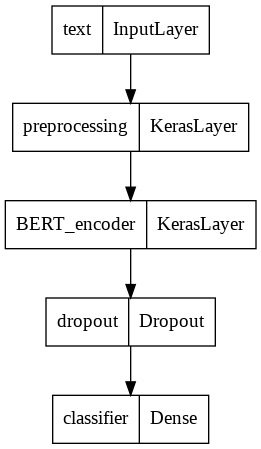

In [21]:
tf.keras.utils.plot_model(classifier_model)

In [22]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

#Evaluation before finetunning

In [23]:
test = list(test_data.iloc[:,0])
test[:5]

['spider legit run chest traumatise life',
 'meek mill join isis love suicidebombe career good reason',
 'wooooooo rt gamerant duty black op 3 esport mode let player ban weapon httptco76ehhmqq6r httptcoumtffa9jjb',
 'like hobbit movie time theatre desolation smaug come feeling',
 'fatherofthree lose control car overtake collide bathandnortheastsomerset httptcofa3fcnln86']

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


original_results = tf.sigmoid(classifier_model(tf.constant(test)))

print('Results from the model before finetunning:')
print_my_examples(test[:5], original_results[:5])

Results from the model before finetunning:
input: spider legit run chest traumatise life : score: 0.443485
input: meek mill join isis love suicidebombe career good reason : score: 0.407375
input: wooooooo rt gamerant duty black op 3 esport mode let player ban weapon httptco76ehhmqq6r httptcoumtffa9jjb : score: 0.406595
input: like hobbit movie time theatre desolation smaug come feeling : score: 0.543183
input: fatherofthree lose control car overtake collide bathandnortheastsomerset httptcofa3fcnln86 : score: 0.457618



In [39]:
_tensor = tf.make_tensor_proto(tf.constant(original_results))
tensor = tf.make_ndarray(_tensor)
array_pred = np.resize(tensor,(len(tensor)))

In [40]:
array_true = np.array(test_data.target)

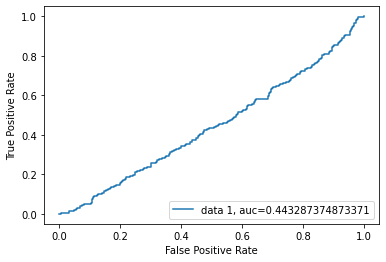

In [27]:
fpr, tpr, thresholds = roc_curve(array_true, array_pred)
auc = roc_auc_score(array_true, array_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

#Fitunning model


In [28]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [29]:
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [30]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [31]:
print('Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')
history = classifier_model.fit(x=train,
                               validation_data=val,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/2
143/143 [==============================] - 321s 2s/step - loss: 0.5122 - binary_accuracy: 0.7539 - val_loss: 0.4155 - val_binary_accuracy: 0.8257
Epoch 2/2
143/143 [==============================] - 287s 2s/step - loss: 0.3721 - binary_accuracy: 0.8485 - val_loss: 0.4177 - val_binary_accuracy: 0.8252


#Result of training

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


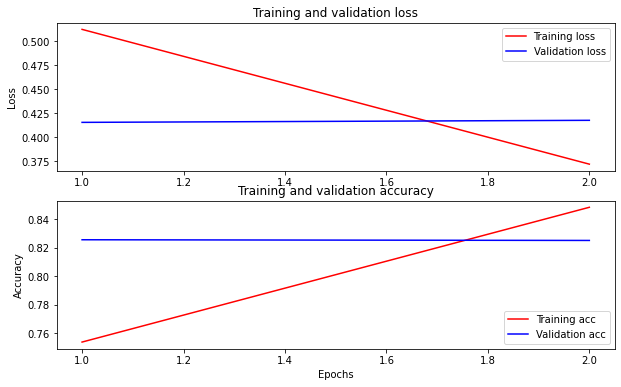

In [32]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [33]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


original_results = tf.sigmoid(classifier_model(tf.constant(test)))

print('Results from the model:')
print_my_examples(test[:5], original_results[:5])

Results from the model:
input: spider legit run chest traumatise life : score: 0.070661
input: meek mill join isis love suicidebombe career good reason : score: 0.060475
input: wooooooo rt gamerant duty black op 3 esport mode let player ban weapon httptco76ehhmqq6r httptcoumtffa9jjb : score: 0.054934
input: like hobbit movie time theatre desolation smaug come feeling : score: 0.073453
input: fatherofthree lose control car overtake collide bathandnortheastsomerset httptcofa3fcnln86 : score: 0.746160



In [34]:
_tensor = tf.make_tensor_proto(tf.constant(original_results))
tensor = tf.make_ndarray(_tensor)
array_pred = np.resize(tensor,(len(tensor)))

In [35]:
mapping = lambda x : 0 if x<0.5 else 1
vfunc = np.vectorize(mapping)
vfunc(tensor)
array_pred_binarized = np.resize(vfunc(tensor),(len(vfunc(tensor))))

In [36]:
array_true = np.array(test_data.target)

In [37]:
precision = precision_score(array_true, array_pred_binarized)
print('Precision: %f' % precision)
recall = recall_score(array_true, array_pred_binarized)
print('Recall: %f' % recall)
f1 = f1_score(array_true, array_pred_binarized)
print('F1 score: %f' % f1)
auc = roc_auc_score(array_true, array_pred)
print('ROC AUC: %f' % auc)

Precision: 0.800487
Recall: 0.785203
F1 score: 0.792771
ROC AUC: 0.894851


##AUC curve after finetunning

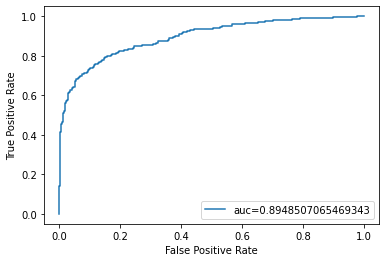

In [41]:
fpr, tpr, thresholds = roc_curve(array_true, array_pred)
auc = roc_auc_score(array_true, array_pred)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()